In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../scms_py')
from scMSData import scMSData
from analysis import scMSAnalysis
from model import scMSModel

import ipywidgets as widgets
from ipywidgets import Box, IntSlider
%matplotlib widget
import numpy as np

In [56]:
import pynndescent
pynndescent.__version__

'0.5.4'

In [2]:
data = pd.read_pickle('data/Aplysia_Data.pkl')
sample_info = pd.read_pickle('data/Aplysia_SampleInfo.pkl')
feature_info = pd.read_pickle('data/Aplysia_Features.pkl')
#X_train, X_test, y_train, y_test = train_test_split(data, sample_info['types'].values, test_size=0.2,random_state=19)

In [3]:
sample_info

,slide_num,types,set,animal
0,221-1,Abdom,1,1
1,221-1,Abdom,1,1
2,221-1,Abdom,1,1
3,221-1,Abdom,1,1
4,221-1,Abdom,1,1
...,...,...,...,...
32388,301-6,Buccal,2,17
32389,301-6,Buccal,2,17
32390,301-6,Buccal,2,17
32391,301-6,Buccal,2,17


In [4]:
sc_db = scMSAnalysis(sample_info)
sc_db.preprocessing(data,norm_method='rms',feat_drop_rate=0.001,cell_drop_rate=0.01)

filtered intensity matrix with shape (19224, 293)


Transforming to str index.


In [5]:
sc_db.get_labels(['types'])

In [6]:
sc_db.analyze(n_neighbors=15, n_pcs=15, min_dist=0.5, resolution = 0.15,
              categories=['types'])

computing neighbors..
performing umap...
performing clustering...


The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'types' as categorical


In [7]:
show_embed = widgets.interactive(sc_db.show_cellEmbed, label=sc_db.adata.obs.columns,
                                 embed_method=sc_db.adata.obsm.keys(),size=(0.01,0.1,0.05),rasterized=True);

In [15]:
show_embed

interactive(children=(Dropdown(description='label', options=('types', 'leiden'), value='types'), Dropdown(desc…

In [17]:
plt.savefig('figures/aplysia_umap_leiden.pdf',dpi=300)

In [18]:
scmodel = scMSModel(sc_db.intens_mtx,metadata=sc_db.metadata)
scmodel.get_labels(['types'])

In [19]:
scmodel.train_models(k=5, cv=False, shap=False, model_names=['GBT'], label_name='types')

performing 1 fold cross validation for GBT
cross validation 0...
[21:49:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion matrix, without normalization
[[ 738   11   10   11   22   48]
 [   1  620    0    2    6    1]
 [  10    1  582    8   28   25]
 [  15    9   15  453   45   16]
 [   8    3    9   16 1537   17]
 [  16    2   12    9   18  482]]


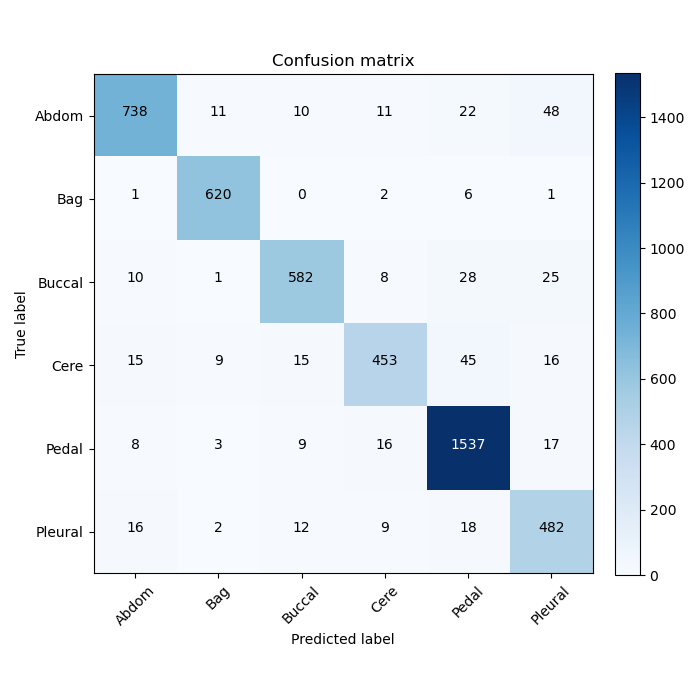

In [52]:
y_pred = scmodel.model['GBT'].predict(scmodel.intens_mtx.loc[scmodel.cv_test[0]].values)
y_test = scmodel.metadata.loc[scmodel.cv_test[0]]['types_int'].values
cf_matrix = confusion_matrix(y_test,y_pred)

plot_confusion_matrix(cf_matrix, classes=scmodel.label_class['types'])
plt.savefig('figures/cm_aplysia.pdf')

In [20]:
from shap import TreeExplainer

e = TreeExplainer(scmodel.model['GBT'])
shap_values = e.shap_values(scmodel.intens_mtx)

In [22]:
shap_df = pd.DataFrame(np.concatenate(shap_values,1))

In [23]:
sc_db_shap = scMSAnalysis(scmodel.metadata.reset_index())
sc_db_shap.preprocessing(shap_df,norm_method='None',feat_drop_rate=0,cell_drop_rate=0)

filtered intensity matrix with shape (19224, 1758)


Transforming to str index.


In [34]:
sc_db_shap.get_labels(['types'])
sc_db_shap.analyze(n_neighbors=30, n_pcs=50, min_dist=0.3, resolution = 0.2,
              categories=['types'])

computing neighbors..
performing umap...
performing clustering...


The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'types' as categorical
invalid value encountered in log2


In [35]:
show_embed = widgets.interactive(sc_db_shap.show_cellEmbed, label=sc_db_shap.adata.obs.columns,
                                 embed_method=sc_db_shap.adata.obsm.keys(),size=(0.01,0.1,0.05));

In [36]:
show_embed

interactive(children=(Dropdown(description='label', options=('types', 'leiden'), value='types'), Dropdown(desc…

In [37]:
plt.savefig('figures/aplysia_umap_supervised_leiden.pdf',dpi=300)

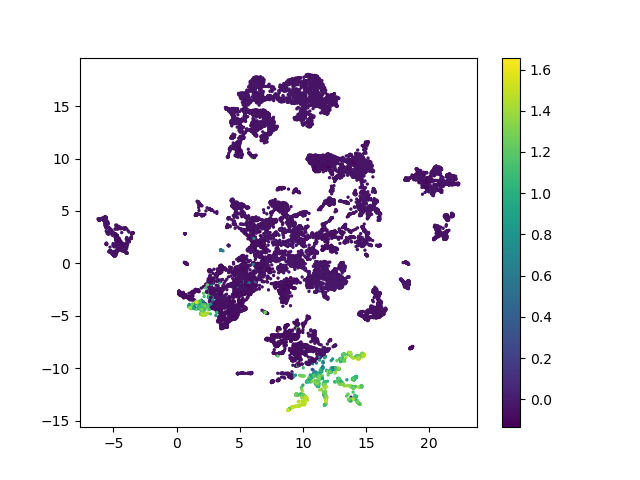

In [42]:
plt.figure()
plt.scatter(sc_db_shap.adata.obsm['X_umap'][:,0],
            sc_db_shap.adata.obsm['X_umap'][:,1],s=2,c=shap_values[4][:,62],rasterized=True)
plt.colorbar()

In [43]:
plt.savefig('figures/aplysia_umap_supervised_shap.pdf',dpi=300)

In [72]:
sc_db.metadata['leiden'] = sc_db_shap.metadata['leiden'].values

In [74]:
sc_db.get_labels(['leiden'])

In [70]:
show_embed_label = widgets.interactive(sc_db_shap.show_cellEmbed_label,label=show_embed.kwargs['label'],
                                 classes=sc_db_shap.label_class[show_embed.kwargs['label']],embed_method=sc_db_shap.adata.obsm.keys(),size=(0.01,0.1,0.05));


In [71]:
show_embed_label

interactive(children=(Text(value='leiden', description='label'), Dropdown(description='classes', options=('0',…

In [79]:
label = 'leiden'
show_feat = widgets.interactive(sc_db.show_featrank, label = label, region = sc_db.label_class[label], 
                                rank_by=sc_db_shap.feat_rank[label].keys(), num_select=500,
                                num_show=IntSlider(min=0, max=500, step=20, value=0));

KeyError: 'leiden'